##### [Draft Express Combine Measurements](http://www.draftexpress.com/nba-pre-draft-measurements/2017/NBA+Draft+Combine/all/all/1/height/desc)

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import re

In [2]:
#download HTML and create Beautiful Soup object
#start 
url = "http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine"

response = requests.get(url)
html = response.content

soup = bs(html, 'lxml')

In [3]:
#find all of the links to the various pages
page_nums = soup.findAll('a', string=re.compile('\d'))

#create list of page labels that aren't the starting page
start_nums = []
for p in page_nums:
    start_nums.append(int(p.string))

print(start_nums)
                      

[2, 3, 4, 5, 6]


In [4]:
#the part of the url that doesn't change from page to page
url_base = 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all'

#create list of page urls
pages = [url_base]
for num in start_nums:
    pages.append(url_base + '/' + str(num))

print(pages)

['http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/2', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/3', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/4', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/5', 'http://www.draftexpress.com/nba-pre-draft-measurements/all/NBA+Draft+Combine/all/all/6']


In [5]:
#retrieve data table from starting pages
table = soup.find('table', attrs={'class': 'sorttable'})

#print(table.prettify())

In [6]:
#create list of column headers
df_headers = []
for item in table.findAll('th'):
    #only include headers that don't contain sub categories
    if item.has_attr("rowspan") and item.get("rowspan") == "2":
        df_headers.append(item.string.strip())

#I had to hard code the columns that contain sub categories i.e. height -> no shoes, shoes; vertical -> max, max reach, no, step, no step reach; hand -> length, width

#set desired start indices for sub categories in list of column headers
height_IDX = 3   
vertical_IDX = 7
hand_IDX = 13

for i in range(len(table.findAll('tr')[1].findAll('th'))):
    item = table.findAll('tr')[1].findAll('th')[i].string.strip()
    
    if i in range(0,2):
        df_headers.insert(height_IDX, item)
        height_IDX += 1
    elif i in range(2,6):
        df_headers.insert(vertical_IDX, item)
        vertical_IDX += 1
    else:
        df_headers.insert(hand_IDX, item)
        hand_IDX += 1
        
print(df_headers)

['Player', 'Year', 'Draft pick', 'No Shoes', 'With Shoes', 'Wingspan', 'Standing reach', 'Max', 'Max Reach', 'No Step', 'No Step Reach', 'Weight', 'Body Fat', 'Length', 'Width', 'Bench', 'Agility', 'Sprint']


In [7]:
#create dictionary from headers list: one for containing data; the other for containing index reference
df_dict = {}
df_idx_ref = {}
idx = 0
for name in df_headers:
    df_dict[name] = []
    df_idx_ref[idx] = name
    idx += 1
    
print("df_dict: {}\n".format(df_dict))
print("df_idx_ref: {}".format(df_idx_ref))

df_dict: {'Player': [], 'Year': [], 'Draft pick': [], 'No Shoes': [], 'With Shoes': [], 'Wingspan': [], 'Standing reach': [], 'Max': [], 'Max Reach': [], 'No Step': [], 'No Step Reach': [], 'Weight': [], 'Body Fat': [], 'Length': [], 'Width': [], 'Bench': [], 'Agility': [], 'Sprint': []}

df_idx_ref: {0: 'Player', 1: 'Year', 2: 'Draft pick', 3: 'No Shoes', 4: 'With Shoes', 5: 'Wingspan', 6: 'Standing reach', 7: 'Max', 8: 'Max Reach', 9: 'No Step', 10: 'No Step Reach', 11: 'Weight', 12: 'Body Fat', 13: 'Length', 14: 'Width', 15: 'Bench', 16: 'Agility', 17: 'Sprint'}


In [8]:
#go through each page to populate df_dict
for page in pages:
    
    url = page
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    table = soup.find('table', attrs={'class': 'sorttable'})

    #populate df_dict with corresponding data from each row
    rows = table.findAll('tr')[2:]

    for row in rows:
        data = row.findAll('td')
        idx = 0
        for d in data:
            if d.has_attr('data-order'):
                if d.get('data-order').strip() in ['-1.0', '-1.00', '-']:
                    df_dict[df_idx_ref[idx]].append(None)
                else:
                    df_dict[df_idx_ref[idx]].append(round(float(d.get('data-order').strip()), 2))

            else:
                #many columns don't contain data-order attribute
                #need to convert data type for columns: max, max reach, no step, no step reach, body fat, bench, agility, sprint
                if idx in [7, 8, 9, 10, 12, 15, 16, 17] and d.text.strip() != '-':
                    df_dict[df_idx_ref[idx]].append(round(float(d.text.strip()),2))
                else:
                    if d.text.strip() == '-':
                        df_dict[df_idx_ref[idx]].append(None)
                    else:
                        df_dict[df_idx_ref[idx]].append(d.text.strip())
            idx += 1

In [9]:
#print out contents of df_dict
for key in df_dict:
    print('{}: {}\n'.format(key, df_dict[key]))

Player: ['Hasheem Thabeet', 'Jordan Bachynski', 'Zhou Qi', 'Jonathan Jeanne', 'Rudy Gobert', 'Alec Brown', 'Jakob Poeltl', 'Byron Mullens', 'Meyers Leonard', 'Frank Kaminsky', 'Thon Maker', 'Solomon Alabi', 'Jerome Jordan', 'Isaiah Austin', 'Thomas Welsh', 'Tyler Zeller', 'Mason Plumlee', 'Willie Cauley-Stein', 'Dakari Johnson', 'Fab Melo', 'Steven Adams', 'Kelly Olynyk', 'Jeff Withey', 'Cody Zeller', 'Robert Upshaw', 'Ryan Richards', 'Hassan Whiteside', 'Miles Plumlee', 'Colton Iverson', 'Skal Labissiere', 'Omer Yurtseven', 'Artsiom Parakhouski', 'Nikola Vucevic', 'Perry Jones', 'Mike Muscala', 'Damian Jones', 'Stephen Zimmerman', 'Zach Collins', 'Josh Heytvelt', 'Keith Benson', 'Jon Leuer', 'Henry Sims', 'DeWayne Dedmon', 'Nerlens Noel', 'Henry Ellenson', 'Justin Patton', 'Moritz Wagner', 'Austin Daye', 'Greg Monroe', 'Enes Kanter', 'Andre Drummond', 'Festus Ezeli', 'Gorgui Dieng', 'Ryan Kelly', 'Myles Turner', 'DeMarcus Cousins', 'Dexter Pittman', 'Arnett Moultrie', 'Norvel Pelle', 

In [10]:
#check to see that each column contains same number of entries
for key in df_dict:
    print("{}: {}".format(key,len(df_dict[key])))

Player: 517
Year: 517
Draft pick: 517
No Shoes: 517
With Shoes: 517
Wingspan: 517
Standing reach: 517
Max: 517
Max Reach: 517
No Step: 517
No Step Reach: 517
Weight: 517
Body Fat: 517
Length: 517
Width: 517
Bench: 517
Agility: 517
Sprint: 517


In [11]:
#convert dictionary to dataframe
df = pd.DataFrame(df_dict, columns=df_dict.keys())

#if draft hasn't occurred, sort dataframe in alphabetical order based on player name; change by argument in sort_values from 'Player' to 'Draft Pick'
#reset index for dataframe
df = df.sort_values(by=['Year', 'Draft pick', 'Player']).reset_index(drop=True)

#rename columns that are subcategories of Height, Vertical, or Hand on Draft Express
df = df.rename(columns= {
    'No Shoes': 'Height (No Shoes)',
    'With Shoes': 'Height (With Shoes)',
    'Max': 'Vertical (Max)',
    'Max Reach': 'Vertical (Max Reach)',
    'No Step': 'Vertical (No Step)',
    'No Step Reach': 'Vertical (No Step Reach)',
    'Length': 'Hand (Length)',
    'Width': 'Hand (Width)'
})

df

,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,Blake Griffin,2009,1,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,Terrence Williams,2009,11,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,Gerald Henderson,2009,12,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,Tyler Hansbrough,2009,13,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,Earl Clark,2009,14,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35
5,Austin Daye,2009,15,81.75,82.75,86.75,110.0,28.0,138.0,25.0,135.0,192.0,5.5,NaN,NaN,NaN,12.11,3.55
6,James Johnson,2009,16,79.00,79.75,84.75,105.5,35.0,140.5,30.5,136.0,257.0,12.0,NaN,NaN,18.0,11.21,3.23
7,Jrue Holiday,2009,17,75.25,76.25,79.00,100.5,34.0,134.5,28.5,129.0,199.0,6.3,NaN,NaN,6.0,10.64,3.21
8,Ty Lawson,2009,18,71.25,72.50,72.75,94.5,36.5,131.0,29.0,123.5,197.0,6.6,NaN,NaN,14.0,10.98,3.12
9,Jeff Teague,2009,19,72.25,73.50,79.50,98.5,36.5,135.0,30.5,129.0,175.0,4.5,NaN,NaN,13.0,11.05,3.18


In [12]:
#get summary statistics of dataframe
round(df.describe(), 2)

,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
count,517.00,516.00,517.00,517.00,450.00,450.00,450.00,450.00,516.00,514.00,470.00,468.00,284.00,444.00,446.00
mean,77.61,78.90,82.50,103.28,35.14,138.17,29.61,132.64,214.83,7.21,8.73,9.40,10.24,11.33,3.30
std,3.29,3.28,3.94,4.90,3.56,4.27,3.06,4.61,24.68,2.48,0.47,0.73,4.94,0.56,0.13
min,68.25,69.50,70.00,88.50,25.00,125.50,22.50,119.00,149.00,3.20,7.50,7.00,1.00,10.07,3.01
25%,75.25,76.75,79.75,100.00,32.50,135.50,27.50,129.50,196.00,5.40,8.50,9.00,6.75,10.94,3.20
50%,77.75,79.00,82.50,103.50,35.00,138.50,29.50,133.00,213.50,6.60,8.75,9.50,10.00,11.26,3.28
75%,80.00,81.25,85.50,107.00,37.50,141.50,31.50,136.00,232.00,8.40,9.00,9.75,14.00,11.66,3.38
max,85.25,86.50,92.50,115.00,44.50,147.50,38.00,144.00,303.00,20.80,10.25,12.00,23.00,13.44,3.81


In [13]:
#create csv file from dataframe
df.to_csv('nba_draft_combine_all_years.csv')

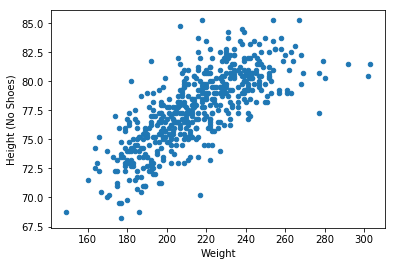

In [14]:
#Can now perform visualization and analysis on dataframe using matplotlib and pandas
import matplotlib.pyplot as plt
%matplotlib inline

#simple scatter plot
df.plot.scatter('Weight', 'Height (No Shoes)')